# Анализ эффективности бизнес-показателей приложения Procrastinate Pro+

Приложение Procrastinate Pro+, несмотря на огромные вложения в рекламу, последние несколько месяцев терпит убытки.

**Цель проекта** - выявить основные причины низкой окупаемости приложения.

**Задачи проекта**:
- Изучить активность пользователей и затраты на их привлечение
- Расчитать основные пользовательские метрики
- Дать рекомендации для отдела маркетинга

**Состав данных** - данные о пользователях, привлечённых с 1 мая по 27 октября 2019 года:
* Лог сервера с данными об их посещениях
* Выгрузка их покупок за этот период
* Рекламные расходы

# Содержание

* [1. Предобработка данных](#1)
* [2. Создание функций для расчета и анализа LTV, ROI, удержания и конверсии](#2)
* [2.1 Функция для расчёта LTV, CAC, ROI](#2.1)
* [2.2 Функция для расчёта Retention Rate](#2.2)
* [2.3 Функция для расчёта Conversion](#2.3)
* [2.4 Функция для визуализации LTV, CAC, ROI](#2.4)
* [2.5 Функция для визуализации Retention Rate и Conversion](#2.5)
* [3. Исследовательский анализ данных](#3)
* [3.1 Определение профилей пользователей](#3.1)
* [3.2 Распределение пользователей по регионам, устройствам и рекламным каналам](#3.2)
* [4. Маркетинг](#4)
* [4.1 Расчёт затрат по источникам и месяцу. Расчёт средней стоимости привлечения одного клиента (CAC)](#4.1)
* [5. Оценка окупаемости рекламы для привлечения пользователей](#5)
* [5.1 Анализ общей окупаемости рекламы](#5.1)
* [5.2 Анализ окупаемости рекламы с разбивкой по устройствам](#5.2)
* [5.3 Анализ окупаемости рекламы с разбивкой по странам](#5.3)
* [5.4 Анализ окупаемости рекламы с разбивкой по рекламным каналам](#5.4)
* [6. Оценка удержания и конверсии](#6)
* [6.1 Анализ удержания и конверсии по устройствам](#6.1)
* [6.2 Анализ удержания и конверсии по странам](#6.2)
* [6.3 Анализ удержания и конверсии по рекламным каналам](#6.3)
* [7. Общие выводы](#7)

<a id="1"></a>
# 1. Предобработка данных

Импортируем все необходимые библиотеки.

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
from plotly.subplots import make_subplots
from plotly import graph_objects as go

Загрузим данные о визитах, заказах и расходах в переменные `data_visits`, `data_orders` и `data_costs`. Поочерёдно посмотрим первые 5 строк и информацию о данных в каждом датасете.

In [2]:
data_visits = pd.read_csv ('C:/Documents/Yandex Practicum/Projects/4. Анализ эффективности бизнес-показателей приложения Procrastinate Pro/data_visits.csv')
data_orders = pd.read_csv ('C:/Documents/Yandex Practicum/Projects/4. Анализ эффективности бизнес-показателей приложения Procrastinate Pro/data_orders.csv')
data_costs = pd.read_csv ('C:/Documents/Yandex Practicum/Projects/4. Анализ эффективности бизнес-показателей приложения Procrastinate Pro/data_costs.csv')

display (data_visits.sample (10))
data_visits.dtypes

,User Id,Region,Device,Channel,Session Start,Session End
258542,396017151338,Germany,Mac,LeapBob,2019-08-10 10:52:39,2019-08-10 11:23:12
150497,345532916208,United States,PC,organic,2019-09-19 16:57:53,2019-09-19 17:43:25
205512,281436339493,United States,iPhone,FaceBoom,2019-10-28 16:57:48,2019-10-28 17:19:06
275476,749521111616,UK,PC,lambdaMediaAds,2019-09-07 00:05:53,2019-09-07 00:10:04
37165,602619144482,United States,Mac,FaceBoom,2019-06-08 02:57:21,2019-06-08 04:00:14
106640,412929848152,United States,Mac,organic,2019-08-13 20:51:33,2019-08-13 21:40:04
156030,863675231778,United States,PC,TipTop,2019-09-23 05:27:03,2019-09-23 05:30:44
291202,51860698117,UK,Mac,WahooNetBanner,2019-10-01 04:59:32,2019-10-01 05:38:36
188093,75383384048,United States,Android,TipTop,2019-10-15 15:18:31,2019-10-15 16:11:46
35644,137828118151,United States,iPhone,FaceBoom,2019-06-06 16:25:42,2019-06-06 16:41:26


User Id           int64
Region           object
Device           object
Channel          object
Session Start    object
Session End      object
dtype: object

В таблице с визитами более 300 тыс записей.

Описание данных:
- `User Id` — уникальный идентификатор пользователя
- `Device` — категория устройства пользователя
- `Session start` — дата и время начала сессии
- `Session End` — дата и время окончания сессии
- `Channel` — идентификатор рекламного источника, из которого пришел пользователь
- `Region` - страна пользователя

Приведём названия колонок к единому формату, а также изменим тип данных в колонках с датой и временем на `datetime`.

In [3]:
data_visits.set_axis (['user_id', 'region', 'device', 'channel', 'session_start', 'session_end'], axis = 1, inplace = True)
data_visits [['session_start', 'session_end']] = data_visits [['session_start', 'session_end']].apply (pd.to_datetime, format = '%Y.%m.%d %H:%M:%S')
data_visits.dtypes

user_id                   int64
region                   object
device                   object
channel                  object
session_start    datetime64[ns]
session_end      datetime64[ns]
dtype: object

Проверим датасет на дубликаты и пропуски данных, а также установим самую раннюю и самую позднюю даты визитов.

In [4]:
data_visits.duplicated().sum()

0

In [5]:
for i in ['region', 'device', 'channel']:
    print (f'Уникальные значения {i}:', data_visits [i].unique(), '\n')

print ('Количество дубликатов в датасете:', data_visits.duplicated().sum())
print ('Количество пропусков в столбцах:\n', data_visits.isna().sum(), '\n')

print ('Начало первой сессии:', data_visits ['session_start'].min())
print ('Начало последней сессии:', data_visits ['session_start'].max())

Уникальные значения region: ['United States' 'UK' 'France' 'Germany'] 

Уникальные значения device: ['iPhone' 'Mac' 'Android' 'PC'] 

Уникальные значения channel: ['organic' 'TipTop' 'RocketSuperAds' 'YRabbit' 'FaceBoom' 'MediaTornado'
 'AdNonSense' 'LeapBob' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds'] 

Количество дубликатов в датасете: 0
Количество пропусков в столбцах:
 user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64 

Начало первой сессии: 2019-05-01 00:00:41
Начало последней сессии: 2019-10-31 23:59:23


Дубликаты и пропуски в данных отсуствуют. Информация о сессиях записана в период с 1 мая по 31 октября 2019 года (6 месяцев).

Рассмотрим таблицу с данными о заказах.

In [6]:
display (data_orders.sample (10))
data_orders.dtypes

,User Id,Event Dt,Revenue
35601,823314125520,2019-09-14 22:42:05,4.99
18364,458461442635,2019-09-16 22:39:53,4.99
14926,746615563937,2019-08-29 09:27:34,5.99
39385,870119707965,2019-10-23 07:40:22,4.99
32723,968421663220,2019-08-09 01:33:04,4.99
1238,822153250439,2019-05-22 11:44:37,4.99
8393,507418622601,2019-07-19 04:05:16,4.99
3189,480028350048,2019-06-11 20:53:27,4.99
5691,919178494191,2019-07-01 12:07:53,4.99
36581,519727161831,2019-09-25 21:52:37,4.99


User Id       int64
Event Dt     object
Revenue     float64
dtype: object

Таблица с заказами имеет более 40 тыс записей и состоит из трёх колонок:

- `User Id` — уникальный id пользователя, который сделал заказ
- `Event Dt` — дата и время покупки
- `Revenue` — выручка

Здесь также следует изменить названия колонок и тип данных в колонке с датой и временем.

In [7]:
data_orders.set_axis (['user_id', 'event_dt', 'revenue'], axis = 1, inplace = True)
data_orders ['event_dt'] = pd.to_datetime (data_orders ['event_dt'], format = '%Y.%m.%d %H:%M:%S')
data_orders.dtypes

user_id              int64
event_dt    datetime64[ns]
revenue            float64
dtype: object

Проверим наличие пропусков и дубликатов в столбцах.

In [8]:
print ('Количество дубликатов в датасете:', data_orders.duplicated().sum())
print ('Количество пропусков в столбцах:\n', data_orders.isna().sum())

Количество дубликатов в датасете: 0
Количество пропусков в столбцах:
 user_id     0
event_dt    0
revenue     0
dtype: int64


Пропуски отсутствуют. Также изучим данные о выручке в колонке `revenue`.

In [9]:
data_orders ['revenue'].describe()

count    40212.000000
mean         5.370608
std          3.454208
min          4.990000
25%          4.990000
50%          4.990000
75%          4.990000
max         49.990000
Name: revenue, dtype: float64

Минимальная покупка составляет `4.99$`, максимальная - `49.99$`, аномальных значений в колонке нет.

Проверим датасет с затратами на маркетинг.

In [10]:
display (data_costs.sample (10))
data_costs.dtypes

,dt,Channel,costs
505,2019-09-23,RocketSuperAds,10.40
283,2019-08-12,MediaTornado,6.00
915,2019-05-16,AdNonSense,32.55
324,2019-09-22,MediaTornado,4.32
1071,2019-10-19,AdNonSense,15.75
312,2019-09-10,MediaTornado,3.36
725,2019-05-06,YRabbit,10.50
1100,2019-05-21,LeapBob,5.67
697,2019-10-05,TipTop,437.50
1188,2019-08-17,LeapBob,11.97


dt          object
Channel     object
costs      float64
dtype: object

Датасет содержит 1800 записей.

Описание данных:
- `Channel` — идентификатор рекламного источника
- `Dt` — дата
- `Costs` — затраты на этот рекламный источник в этот день

Скорректируем название колонки `channel` и тип данных колонки `dt`.

In [11]:
data_costs.rename ({'Channel': 'channel'}, axis = 1, inplace = True)
data_costs ['dt'] = pd.to_datetime (data_costs ['dt'], format = '%Y.%m.%d %H:%M:%S')
data_costs.dtypes

dt         datetime64[ns]
channel            object
costs             float64
dtype: object

Проверим дубликаты в колонке `channel`, пропуски в данных и информацию о затратах.

In [12]:
print ('Уникальные значения channel:', data_costs ['channel'].unique())
print ('\nКоличество дубликатов в датасете:', data_orders.duplicated().sum())
print ('\nКоличество пропусков в столбцах:\n', data_costs.isna().sum(), '\n\nДанные о затратах:')
data_costs ['costs'].describe()

Уникальные значения channel: ['FaceBoom' 'MediaTornado' 'RocketSuperAds' 'TipTop' 'YRabbit'
 'AdNonSense' 'LeapBob' 'OppleCreativeMedia' 'WahooNetBanner'
 'lambdaMediaAds']

Количество дубликатов в датасете: 0

Количество пропусков в столбцах:
 dt         0
channel    0
costs      0
dtype: int64 

Данные о затратах:


count    1800.000000
mean       58.609611
std       107.740223
min         0.800000
25%         6.495000
50%        12.285000
75%        33.600000
max       630.000000
Name: costs, dtype: float64

Дубликаты и пропуски отсутствуют. Максимальные затраты на рекламу за день составляют `630$`, что является очень высоким значением. Посмотрим на распределение значений.

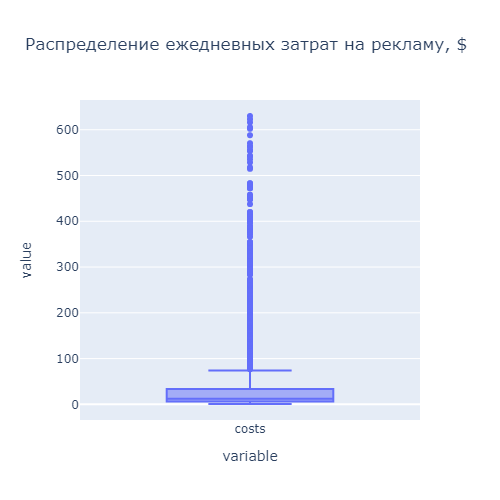

In [13]:
fig_1 = px.box (data_costs ['costs'], height = 500, width = 500, title = 'Распределение ежедневных затрат на рекламу, $')
fig_1.show ('png')

Диаграмма размаха показывает множество значений в диапазоне от `100$` до `600$`, из чего можно делать вывод о том, что максимальное значение не является ошибкой или аномалией. Можно приступать к расчёту необходимых показателей.

<a id="2"></a>
# 2. Создание функций для расчета и анализа LTV, ROI, удержания и конверсии

<a id="2.1"></a>
**2.1 Функция для расчёта LTV, CAC, ROI**

In [14]:
def ltv_roi (profiles, orders, current_date, horizon, group = []):
    
    ltv_raw = profiles.query ('dt <= @current_date').merge (data_orders, on = 'user_id', how = 'left')
    ltv_raw ['lifetime'] = (ltv_raw ['event_dt'] - ltv_raw ['first_session']).dt.days
    
    if len (group) == 0:
        ltv_raw ['group'] = 'all users'
        group = group + ['group']
        
    def ltv_roi_ (data, groups, horizon):
        ltv_table = data.pivot_table (index = groups, columns = 'lifetime', values = 'revenue', aggfunc = 'sum')
        ltv_table = ltv_table.fillna (0).cumsum (axis = 1)
        cohort_size = ltv_raw.groupby (groups).agg ({'user_id': 'nunique'}).rename ({'user_id': 'cohort_size'}, axis = 1)
        ltv_table = cohort_size.merge (ltv_table, on = groups, how = 'left').fillna (0)
        ltv_table = ltv_table.div (ltv_table ['cohort_size'], axis = 0)
        ltv_table = ltv_table [['cohort_size'] + list (range (horizon))]
        ltv_table ['cohort_size'] = cohort_size
        
        cac = data [['user_id', 'cac'] + groups].drop_duplicates()
        cac = cac.groupby (groups).agg ({'cac': 'mean'})
        
        roi = ltv_table.div (cac ['cac'], axis = 0)
        roi = roi [~ roi ['cohort_size'].isin ([np.inf])]
        roi ['cohort_size'] = cohort_size
        roi ['cac'] = cac['cac']
        roi = roi [['cohort_size', 'cac'] + list (range(horizon))]
        
        return ltv_table, roi
    
    ltv, roi = ltv_roi_ (ltv_raw, group, horizon)
    
    if 'group' in group:
        group = []       
    ltv_dynamics, roi_dynamics = ltv_roi_ (ltv_raw, group + ['dt'], horizon)
    
    return ltv_raw, ltv, ltv_dynamics, roi, roi_dynamics

<a id="2.2"></a>
**2.2 Функция для расчёта Retention Rate**

In [15]:
def get_retention (profiles, visits, current_date, horizon, group = []):
    
    group = ['payer'] + group
    retention_raw = profiles.query ('dt <= @current_date').merge (visits [['user_id', 'session_start']],
                                                                  on = 'user_id',
                                                                  how = 'left')
    retention_raw ['lifetime'] = (retention_raw ['session_start'] - retention_raw ['first_session']).dt.days

    def retention_ (data, groups, horizon):        
        retention_table = data.pivot_table (index = groups, columns = 'lifetime', values = 'user_id', aggfunc ='nunique')
        cohort_size = (data.groupby (groups).agg ({'user_id': 'nunique'}).rename ({'user_id': 'cohort_size'}, axis = 1))
        retention_table = cohort_size.merge (retention_table, on = groups, how = 'left').fillna (0)
        retention_table = retention_table.div (retention_table ['cohort_size'], axis = 0)
        retention_table = retention_table [['cohort_size'] + list (range (horizon))]
        retention_table ['cohort_size'] = cohort_size
        return retention_table
    
    retention = retention_ (retention_raw, group, horizon)
    retention_dynamics = retention_ (retention_raw, group + ['dt'], horizon)
    
    return retention_raw, retention, retention_dynamics

<a id="2.3"></a>
**2.3 Функция для расчёта Conversion**

In [16]:
def get_conversion (profiles, orders, current_date, horizon, group = []):
    
    conversion_raw = profiles.query ('dt <= @current_date')
    
    if len (group) == 0:
        conversion_raw ['group'] = 'all users' 
        group = group + ['group']
        
    first_orders = orders.sort_values (by = ['user_id', 'event_dt']).groupby ('user_id') .agg ({'event_dt': 'first'}).reset_index()
                
    conversion_raw = conversion_raw.merge (first_orders [['user_id', 'event_dt']], on = 'user_id', how = 'left')
    conversion_raw ['lifetime'] = (conversion_raw ['event_dt'] - conversion_raw ['first_session']).dt.days

    def conversion_ (data, groups, horizon):
        conversion_table = data.pivot_table (index = groups, columns = 'lifetime', values = 'user_id', aggfunc = 'nunique')
        conversion_table = conversion_table.fillna (0).cumsum (axis = 1)
        cohort_size = (data.groupby (groups).agg ({'user_id': 'nunique'}).rename ({'user_id': 'cohort_size'}, axis = 1))
        conversion_table = cohort_size.merge (conversion_table, on = groups, how = 'left').fillna (0)
        conversion_table = conversion_table.div (conversion_table ['cohort_size'], axis = 0)
        conversion_table = conversion_table [['cohort_size'] + list (range (horizon))]
        conversion_table ['cohort_size'] = cohort_size
        return conversion_table

    conversion = conversion_ (conversion_raw, group, horizon)

    if 'group' in group: 
        group = []

    conversion_dynamics = conversion_ (conversion_raw, group + ['dt'], horizon)

    return conversion_raw, conversion, conversion_dynamics

<a id="2.4"></a>
**2.4 Функция для визуализации LTV, CAC, ROI**

In [17]:
def moving_average (data, window):
    
    data_copy = data.copy()
    for i in data_copy.columns.values:
        data_copy [i] = data_copy [i].rolling (window).mean()
    return data_copy

def plot_ltv_roi (ltv, ltv_dynamics, roi, roi_dynamics, horizon, window, group = []):
    
    if len (group) == 0:
        name = 'all users'
    else:
        name = group [0]
        
    ltv_dynamics = ltv_dynamics.drop ('cohort_size', axis = 1)[[horizon - 1]]
    ltv_dynamics_pivot = ltv_dynamics.pivot_table (index = 'dt',
                                              columns = group,
                                              values = horizon - 1,
                                              aggfunc = 'mean')

    cac_dynamics = roi_dynamics [['cac']]
    cac_dynamics_pivot = cac_dynamics.pivot_table (index = 'dt', columns = group, values = 'cac', aggfunc = 'mean')
    
    roi_dynamics_pivot = roi_dynamics.pivot_table (index = 'dt',
                                                   columns = group,
                                                   values = horizon - 1,
                                                   aggfunc = 'mean')

    fig_1 = px.imshow (ltv.drop (columns = ['cohort_size']))
    fig_1.update_layout (title_text = f'Тепловая карта LTV по {name}, $', xaxis_title = 'Лайфтайм')

    fig_2 = px.line (moving_average (ltv_dynamics_pivot, window))
    fig_2.update_layout (title_text = f'Динамика LTV по {name}, $', xaxis_title = 'Время')
    
    fig_3 = px.line (cac_dynamics_pivot)
    fig_3.update_layout (title_text = f'Динамика CAC по {name}, $', xaxis_title = 'Время')
    
    fig_4 = px.line (roi.drop (['cohort_size', 'cac'], axis = 1).T)
    fig_4.add_hline (y = 1, line_dash = 'dash', annotation_text = 'Уровень окупаемости')
    fig_4.update_layout (title_text = f'ROI по {name}', xaxis_title = 'Лайфтайм')
    
    fig_5 = px.line (moving_average (roi_dynamics_pivot, window))
    fig_5.add_hline (y = 1, line_dash = 'dash', annotation_text = 'Уровень окупаемости')
    fig_5.update_layout (title_text = f'Динамика ROI по {name}', xaxis_title = 'Время')
    
    for i in (fig_1, fig_2, fig_3, fig_4, fig_5):
        i.update_layout (height = 600, width = 1000)
        i.show ('png')

def get_plot_ltv_roi (prof, data, date, horizon, window, group = []):
    
    ltv_raw, ltv, ltv_dynamics, roi, roi_dynamics = ltv_roi (prof, data, date, horizon, group)
    plot_ltv_roi (ltv, ltv_dynamics, roi, roi_dynamics, horizon, window, group)

<a id="2.5"></a>
**2.5 Функция для визуализации Retention Rate и Conversion**

In [18]:
def plot_retention_conversion (retention, retention_dynamics, conversion, conversion_dynamics, horizon, window, group):
    
    retention = retention.drop (['cohort_size', 0], axis = 1)
    retention_dynamics = retention_dynamics.drop (['cohort_size'], axis = 1)[[horizon - 1]].pivot_table (index = ['payer', 'dt'],
                                                                                                         columns = group,
                                                                                                         values = horizon - 1,
                                                                                                         aggfunc = 'mean')
    conversion = conversion.drop ('cohort_size', axis = 1).T
    conversion_dynamics = moving_average (conversion_dynamics.drop (['cohort_size'],
                                                                    axis = 1)[[horizon - 1]].pivot_table (index = 'dt',
                                                                                                          columns = group,
                                                                                                          values = horizon - 1,
                                                                                                          aggfunc = 'mean'), window)
    retention_payers_true = retention.query ('payer == True').droplevel ('payer').T
    retention_payers_false = retention.query ('payer == False').droplevel ('payer').T
    retention_dynamics_true = moving_average (retention_dynamics.query ('payer == True').droplevel ('payer'), window)
    retention_dynamics_false = moving_average (retention_dynamics.query ('payer == False').droplevel ('payer'), window)
    line_colors = ['red',
                   'mediumblue',
                   'limegreen',
                   'orange',
                   'lightpink',
                   'blueviolet',
                   'lightgrey',
                   'deepskyblue',
                   'crimson',
                   'darkseagreen',
                   'olive']
    
    row_count = 1
    col_count = 0
    legend = True
    
    fig = make_subplots (rows = 3,
                         cols = 2,
                         shared_yaxes = True,
                         subplot_titles = ('Retention Rate с оплатой',
                                           'Retention Rate без оплаты',
                                           'Динамика Retention Rate с оплатой',
                                           'Динамика Retention Rate без оплаты',
                                           'Conversion',
                                           'Динамика Conversion'))
    
    for i in [retention_payers_true,
              retention_payers_false,
              retention_dynamics_true,
              retention_dynamics_false,
              conversion,
              conversion_dynamics]:

        if col_count != 0:
            legend = False
        col_count += 1

        if col_count > 2:
            col_count = 1
            row_count += 1
            
        for j in range (len (i.columns)):
            fig.add_trace (go.Scatter (x = i.index,
                                       y = i [i.columns [j]],
                                       name = i.columns [j],
                                       line_color = line_colors [j],
                                       showlegend = legend),
                           row = row_count, col = col_count)
            
    fig.update_layout (height = 1500, width = 1200, title_text = f'Retention Rate и Conversion по {group [0]}')
    fig.show ('png')

def get_plot_retention_convertion (prof, visits, orders, date, horizon, window, group = []):
    retention_raw, retention, retention_dynamics = get_retention (prof, visits, date, horizon, group)
    conversion_raw, conversion, conversion_dynamics = get_conversion (prof, orders, date, horizon, group)
    plot_retention_conversion (retention, retention_dynamics, conversion, conversion_dynamics, horizon, window, group)

<a id="3"></a>
# 3. Исследовательский анализ данных
<a id="3.1"></a>
**3.1 Определение профилей пользователей**

Определим профили пользователей, сгруппировав данные по `user_id` и `session_start`, оставив при этом данные о первом знакомстве пользователя с приложением. Также добавим столбец `payer` с информацией о овершении покупок пользователем.

In [19]:
profiles = data_visits.sort_values (by = ['user_id',
                                         'session_start']).groupby ('user_id').agg ({'session_start': 'first',
                                                                                     'channel': 'first',
                                                                                     'device': 'first',
                                                                                     'region': 'first'}).rename ({'session_start': 'first_session'},
                                                                                                                 axis = 1).reset_index()
profiles ['payer'] = profiles ['user_id'].isin (data_orders ['user_id'].unique())
min_date = profiles ['first_session'].min ()
max_date = profiles ['first_session'].max ()
display (profiles.sample (10))
print (f'Минимальная дата привлечения пользователей: {min_date}\nМаксимальная дата привлечения пользователей: {max_date}')

,user_id,first_session,channel,device,region,payer
142948,953964476485,2019-10-24 07:58:52,LeapBob,Android,France,False
113958,759699136506,2019-09-04 17:48:46,OppleCreativeMedia,PC,UK,False
80572,535073920793,2019-06-02 16:58:40,RocketSuperAds,Android,United States,False
17960,119470178253,2019-09-10 21:48:29,organic,Mac,United States,False
114767,764992204362,2019-06-04 20:01:59,OppleCreativeMedia,PC,UK,False
36379,241509859213,2019-10-27 15:18:51,YRabbit,iPhone,United States,False
110714,737416434220,2019-06-20 02:54:06,FaceBoom,PC,United States,False
28857,191897900113,2019-08-02 16:40:31,LeapBob,Mac,Germany,False
116008,772989637601,2019-09-05 00:45:10,FaceBoom,iPhone,United States,True
42424,281192122851,2019-05-13 04:37:09,AdNonSense,Android,Germany,False


Минимальная дата привлечения пользователей: 2019-05-01 00:00:41
Максимальная дата привлечения пользователей: 2019-10-27 23:59:04


После группировки размер датасета сократился примерно в 2 раза. Изучим информацию о платящих и неплатящих пользователях, сравним их активность по полученным профилям.
<a id="3.2"></a>

**3.2 Распределение пользователей по регионам, устройствам и рекламным каналам**

Создадим функцию `selection_show` для получения нужной выборки и её визуализации.

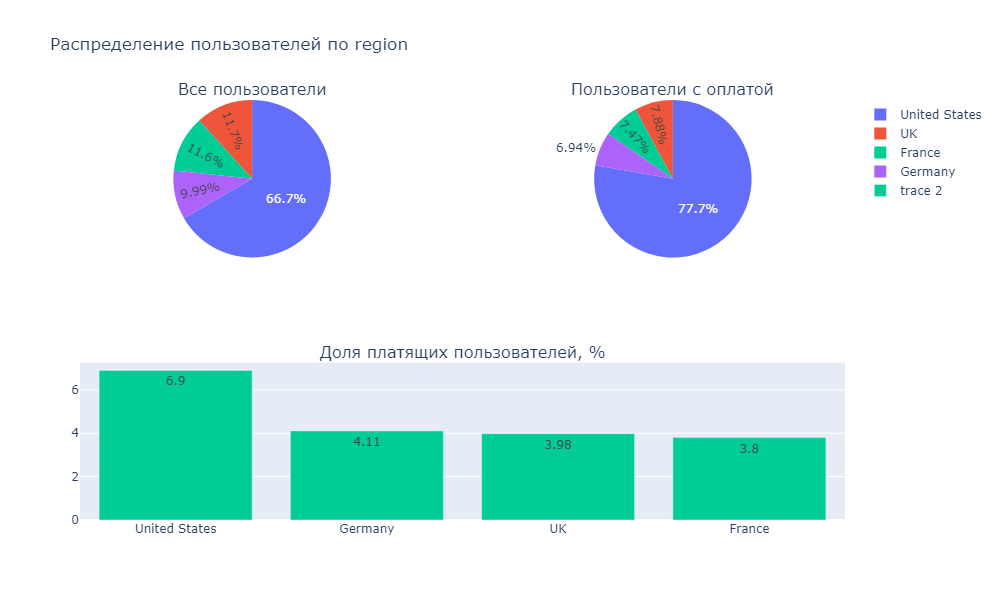

In [20]:
def selection_show (group):
    selection = profiles.groupby (group)['user_id'].count().reset_index()
    selection = selection.merge (profiles.query ('payer == True').groupby (group)['user_id'].count().reset_index(),
                                 on = group).set_axis ([group, 'all_users', 'payers'], axis = 1)
    selection ['ratio'] = round ((selection ['payers'] / selection ['all_users'] * 100), 2)
    selection.sort_values (by = 'ratio', ascending = False, inplace = True)
    
    fig = make_subplots (rows = 2, cols = 2,
                         specs = [[{'type': 'domain'},
                                   {'type': 'domain'}],
                                  [{'colspan': 2}, None]],
                         subplot_titles = ('Все пользователи',
                                           'Пользователи с оплатой',
                                           'Доля платящих пользователей, %'))

    for i, j in ['all_users', 1], ['payers', 2]:
        fig.add_trace (go.Pie (labels = selection [group], values = selection [i]), row = 1, col = j) 

    fig.add_trace (go.Bar (x = selection [group], y = selection ['ratio'], text = selection ['ratio']), row = 2, col = 1)
    fig.update_layout (height = 600, width = 1000, title_text = f'Распределение пользователей по {group}')
    fig.show ('png')

selection_show ('region')

**Вывод:** Соединённые штаты лидируют в количестве пользователей и полученных оплат. Доля платящих пользователей в США достигает практически 7% - это выше, чем у других стран. На втором месте по конверсии - Германия (4.1%). Оплаты пользователей в Великобритании и Франции не превышает 4%. В целом, это очень низкие показатели для конверсии. Для выяснения причины таких низких показателей стоит рассмотреть активность пользователей по другим критериям.

Проверим распределение пользователей в зависимости от типа устройств.

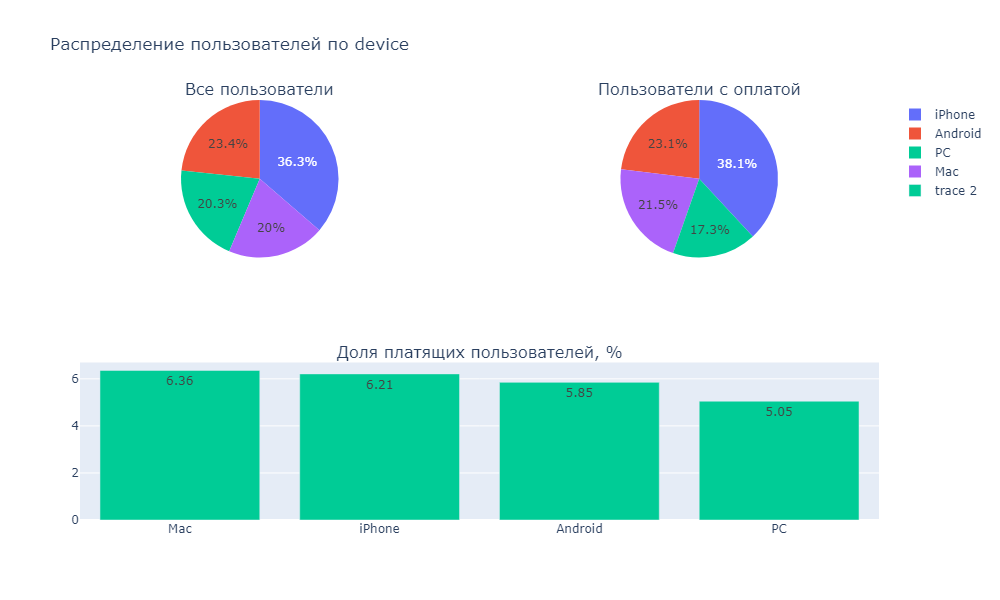

In [21]:
selection_show ('device')

**Вывод:** Общее распределение всех пользователей и платящих пользователей по устройствам примерно одинаковое. Наиболее популярный тип устройства - iPhone. Однако, наиболее высокая доля оплат приходится на пользователей Mac, в то время, как в общем распределении количество пользователей Mac находится на последних позициях. Конверсия по каждому из устройств не превышает 7%, что является очень низким показателем.

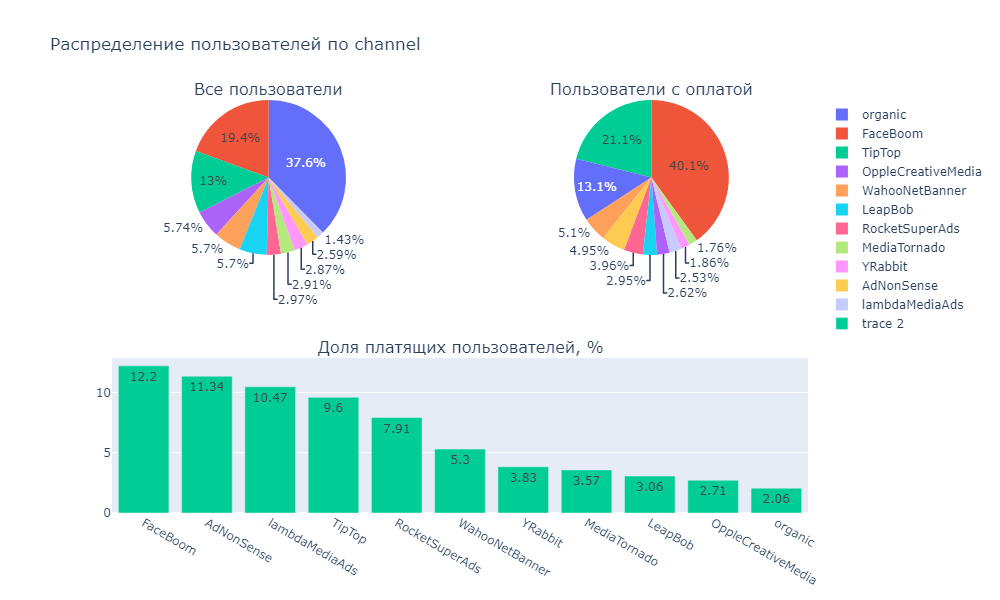

In [22]:
selection_show ('channel')

**Вывод:** ТОП-3 канала по привлечению клиентов - `Organic` (37,6%), `FaceBoom` (19,4%) и `TipTop` (13%). `FaceBoom` и `TipTop` также имеют высокие проценты среди платящих пользователей, в то время как пользователи, пришедшие без рекламы, имеют наименьший процент оплат в общем объёме пользователей данной категории.

Также средует отметить каналы `AdNonSense` и `lambdaMediaAds` - они имеет малую долю среди оплативших пользователей, но высокую долю среди всех пользователей этой категории. Это говорит о качестве рекламного источника и возможном потенциале при увеличении рекламного бюджета в этих каналах.

<a id="4"></a>
# 4. Маркетинг
<a id="4.1"></a>

**4.1 Расчёт затрат по источникам и месяцу. Расчёт средней стоимости привлечения одного клиента (CAC)**

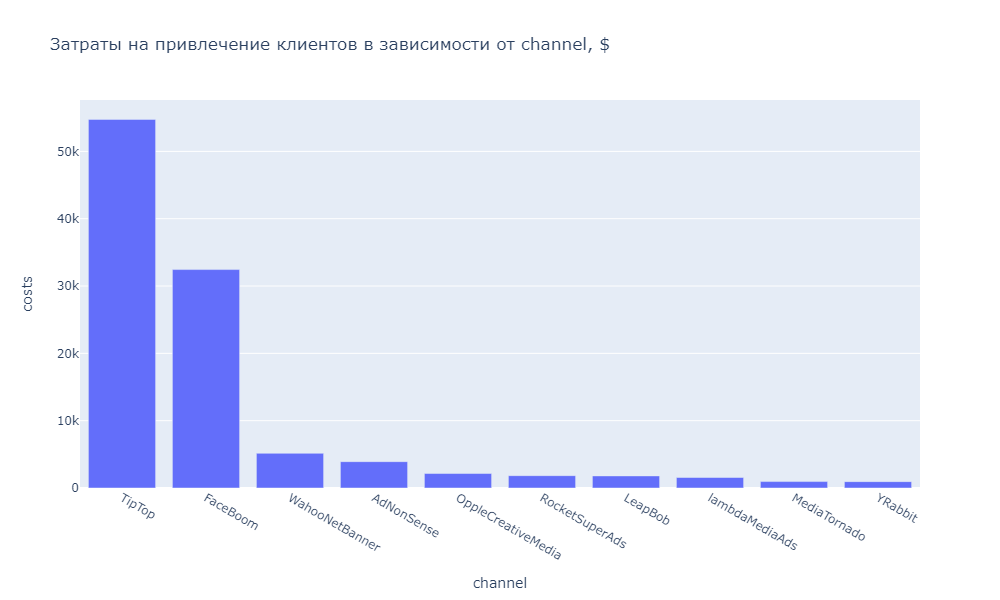

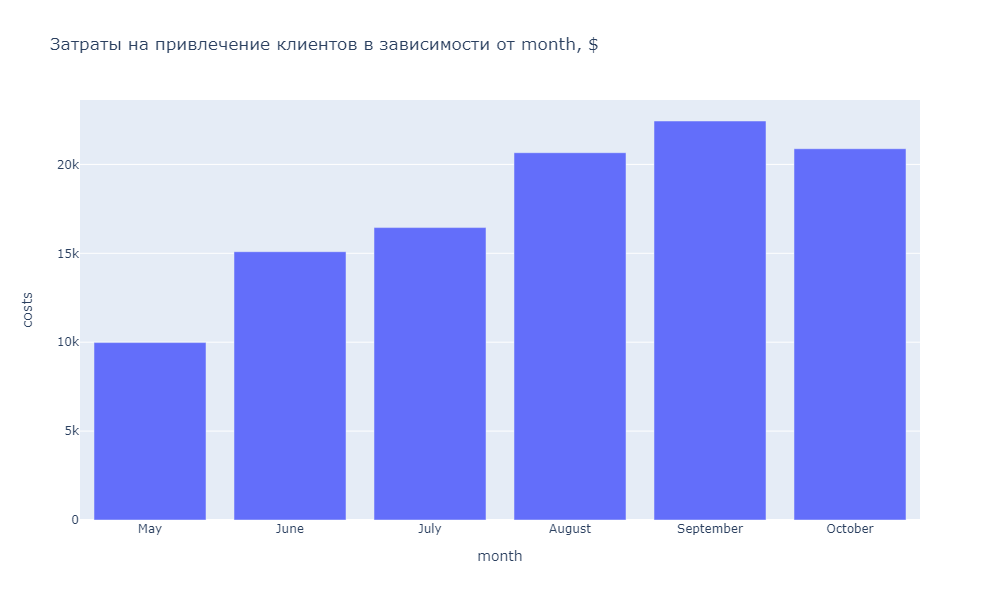

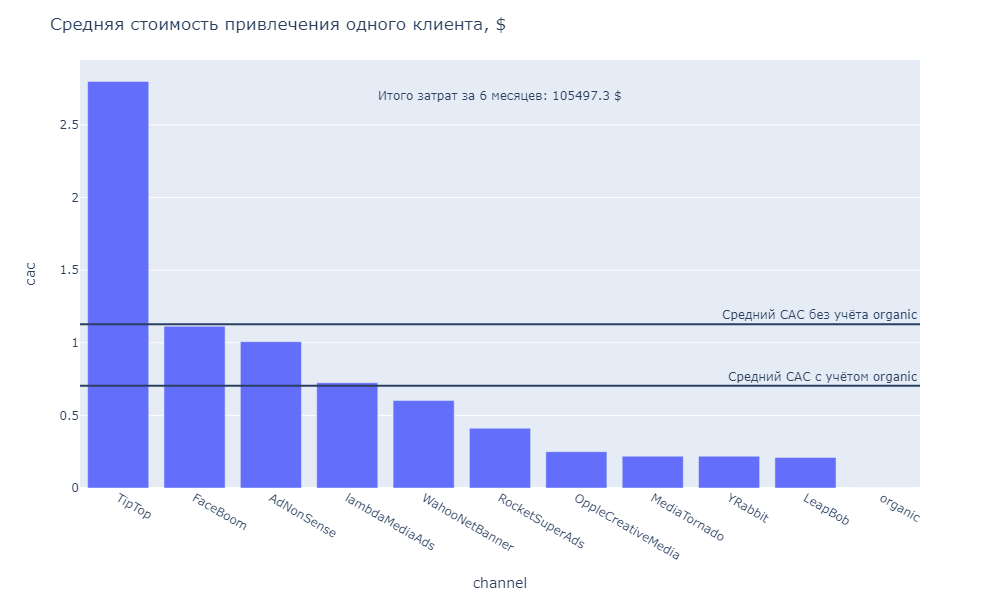

In [23]:
data_costs ['month'] = data_costs ['dt'].dt.month_name()
data_costs ['month_num'] = data_costs ['dt'].dt.month
cost_by_channel = data_costs.groupby ('channel')['costs'].sum().sort_values (ascending = False).reset_index()
cost_by_month = data_costs.groupby (['month', 'month_num'])['costs'].sum().reset_index().sort_values (by = 'month_num')

for i, j in [cost_by_channel, 'channel'], [cost_by_month, 'month']:
    fig = px.bar (i,
                  x = j,
                  y = 'costs',
                  title = f'Затраты на привлечение клиентов в зависимости от {j}, $',
                  height = 600,
                  width = 1000)
    fig.show ('png')

profiles ['dt'] = pd.to_datetime (profiles ['first_session'].dt.date)
profiles_group = (profiles.groupby (['dt', 'channel'])
                          .agg ({'user_id': 'nunique'})
                          .rename ({'user_id': 'users'},axis = 1)
                          .reset_index())

profiles_group = profiles_group.merge (data_costs, on = ['dt', 'channel'], how = 'left')
profiles_group ['cac'] = round (profiles_group ['costs'] / profiles_group ['users'], 2)

profiles = profiles.merge (profiles_group [['dt', 'channel', 'cac']],
                           on = ['dt', 'channel'],
                           how = 'left').fillna (0)

cac_by_channel = profiles.groupby ('channel')['cac'].mean().sort_values (ascending = False).reset_index()
cac_mean_1 = profiles.query ('channel != "organic"')['cac'].mean()
cac_mean_2 = profiles ['cac'].mean()
total_cost = round (data_costs ['costs'].sum(), 2)

fig_2 = px.bar (cac_by_channel, x = 'channel', y = 'cac', height = 600, width = 1000)
fig_2.add_hline (y = cac_mean_1, annotation_text = 'Средний CAC без учёта organic')
fig_2.add_hline (y = cac_mean_2, annotation_text = 'Средний CAC с учётом organic')
fig_2.add_annotation (text = f'Итого затрат за 6 месяцев: {total_cost} $', x = 5, y = 2.7, showarrow = False)
fig_2.update_layout (title_text = 'Средняя стоимость привлечения одного клиента, $')
fig_2.show ('png')

**Вывод:**

Затраты на `TipTop` и `FaceBoom` в совокупности превышают 85000$, что составляет основную долю потраченного бюджета, при этом затраты на рекламу в среднем ежемесячно увеличивались. Данные каналы также являются наиболее затратными по показателю CAC.

Средняя стоимость привлечения через канал `AdNonSense` практически такая же высокая, как и у `FaceBoom`, в то время как затраты на привлечение в этих двух каналах различаются более чем в 8 раз.

Каналы `YRabbit`, `MediaTornado` и `LeapBob` наименее затратные среди всех остальных.

Также стоит отметить, что пользователи из категории `organic` значительно влияют на средний показатель CAC для всего проекта, что говорит о важности условно "бесплатных" клиентов для приложения.

<a id="5"></a>
# 5. Оценка окупаемости рекламы для привлечения пользователей
<a id="5.1"></a>

**5.1 Анализ общей окупаемости рекламы**

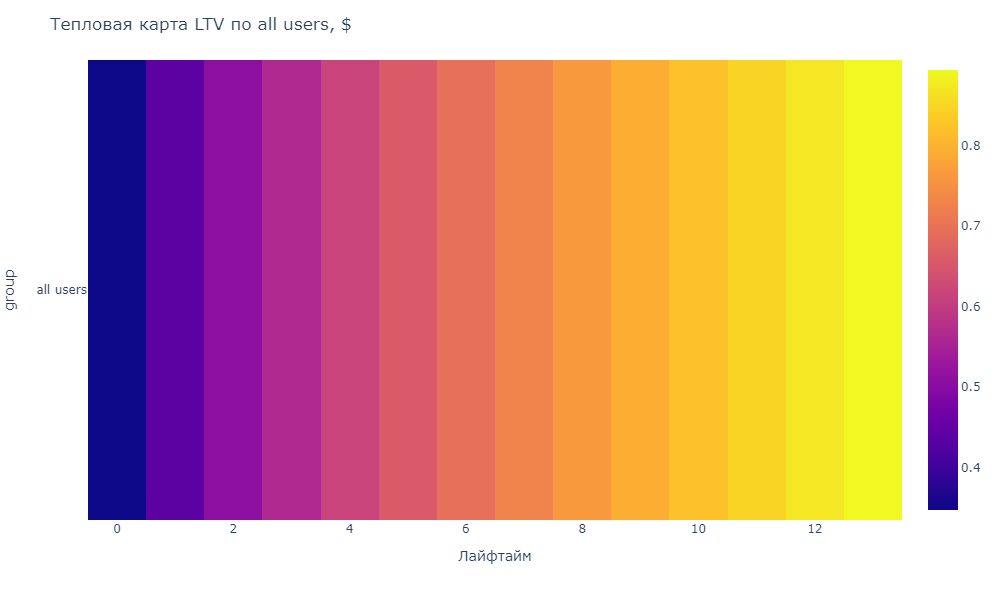

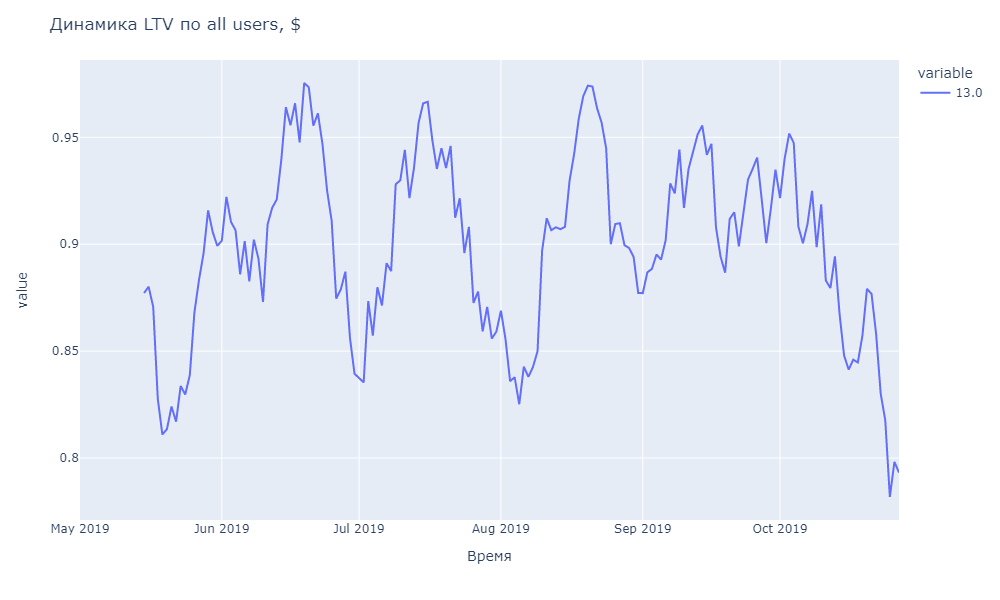

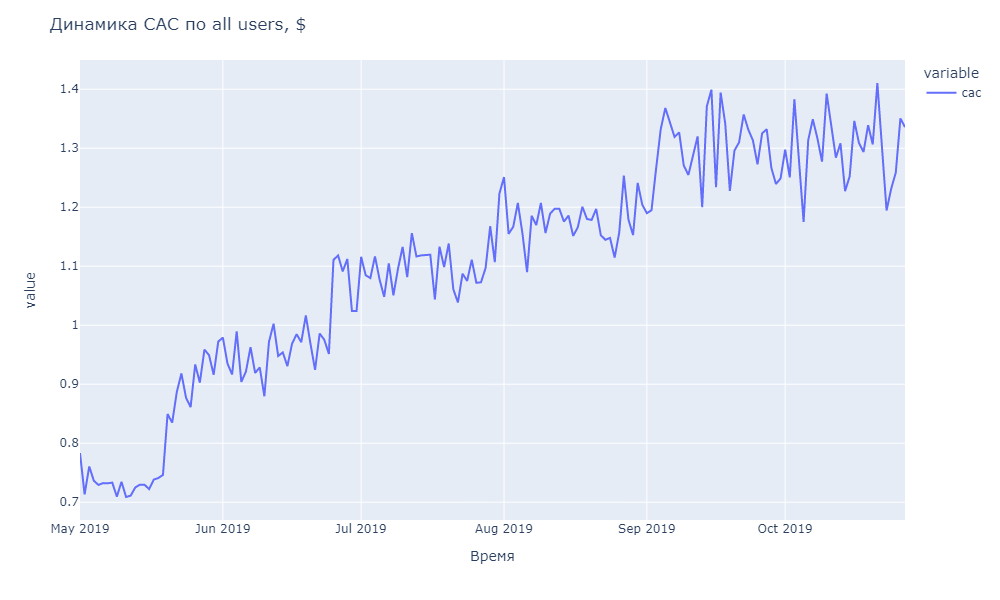

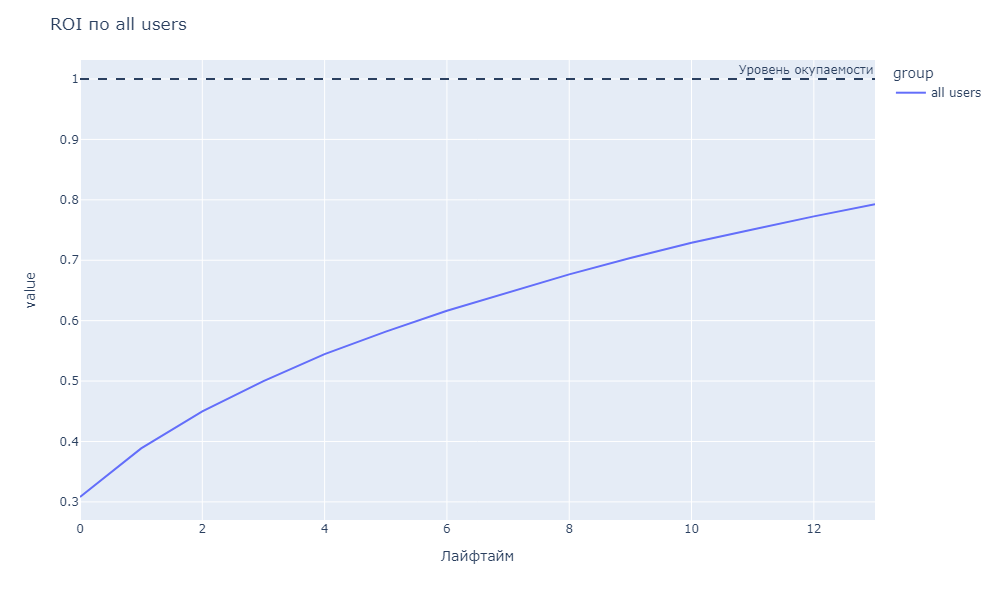

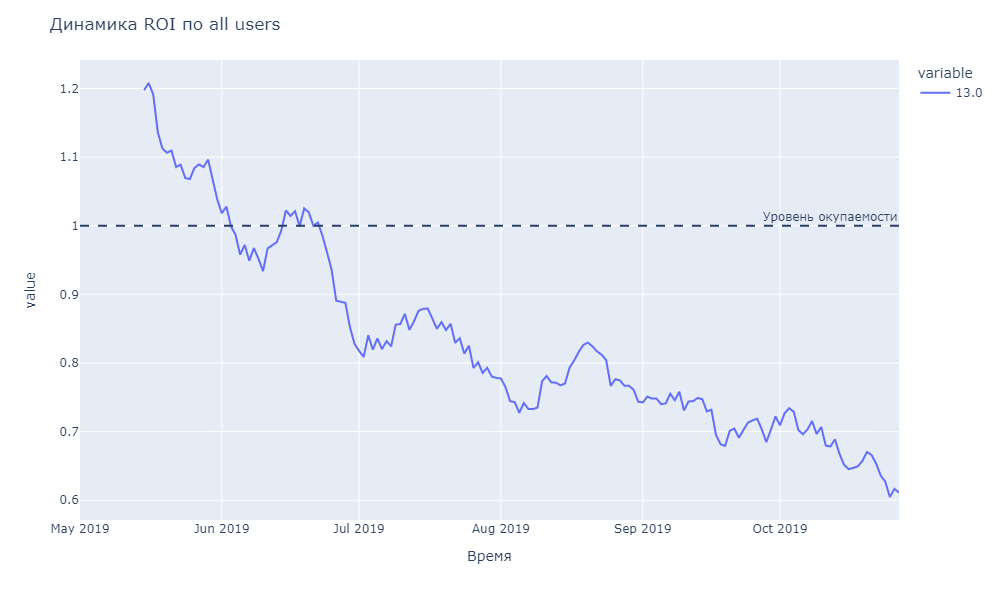

In [24]:
profiles_without_organic = profiles.query ('channel != "organic"')
get_plot_ltv_roi (profiles_without_organic, data_orders, '2019.11.01', 14, 15)

**Вывод:**

Начиная с середины июня LTV теряет положительную динамику, а в последний месяц вовсе падает ниже майских значений, при этом стоимость привлечения пользователей из месяца в месяц только увеличивается. Это может говорить о низком качестве рекламных каналов или в постоянном увеличении рекламного бюджета.

Проект не окупается. По истечению двух недель ROI достигает 79%, при этом динамика ROI снижается параллельно увеличению CAC.

<a id="5.2"></a>
**5.2 Анализ окупаемости рекламы с разбивкой по устройствам**

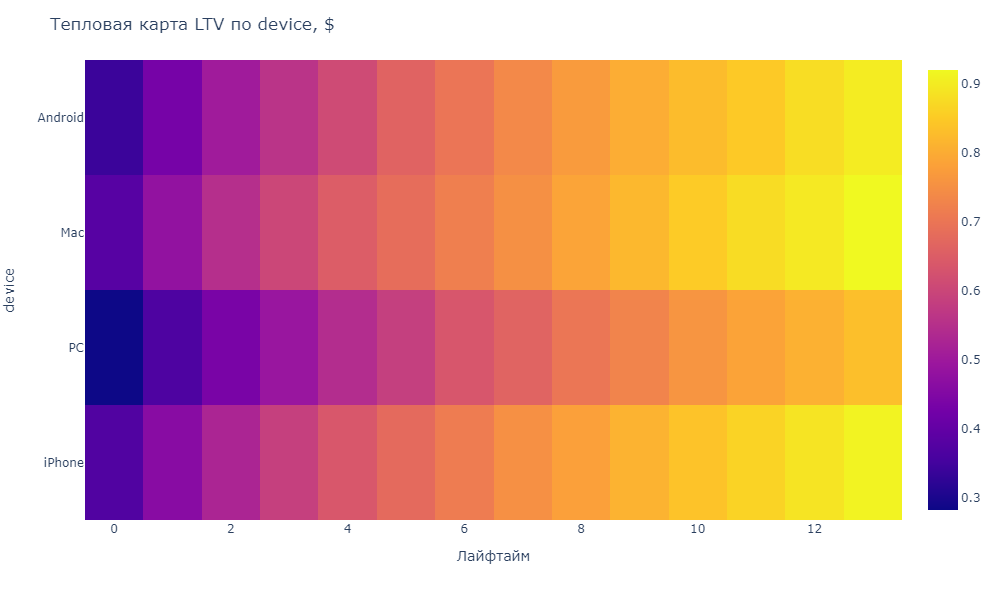

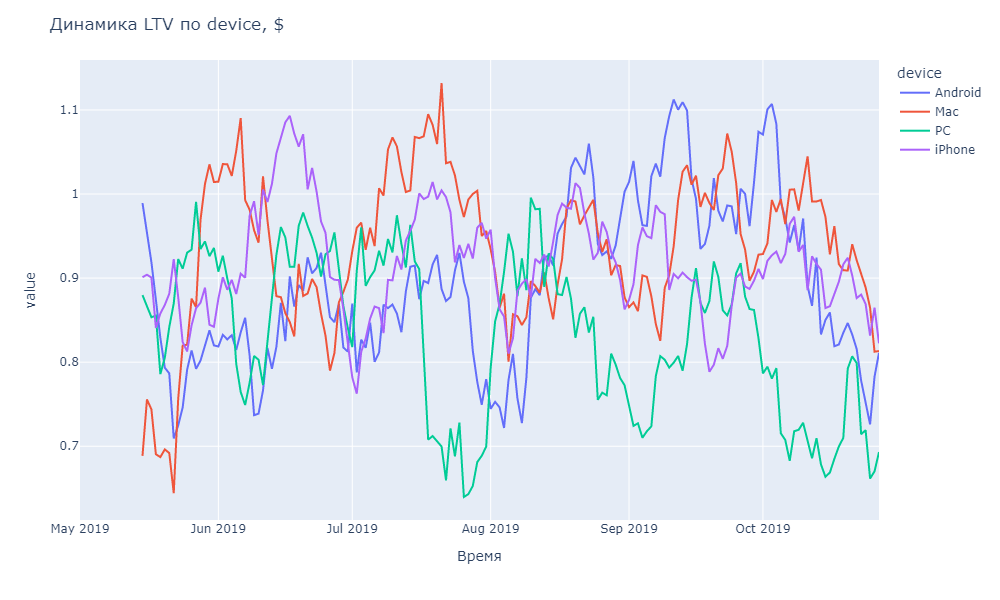

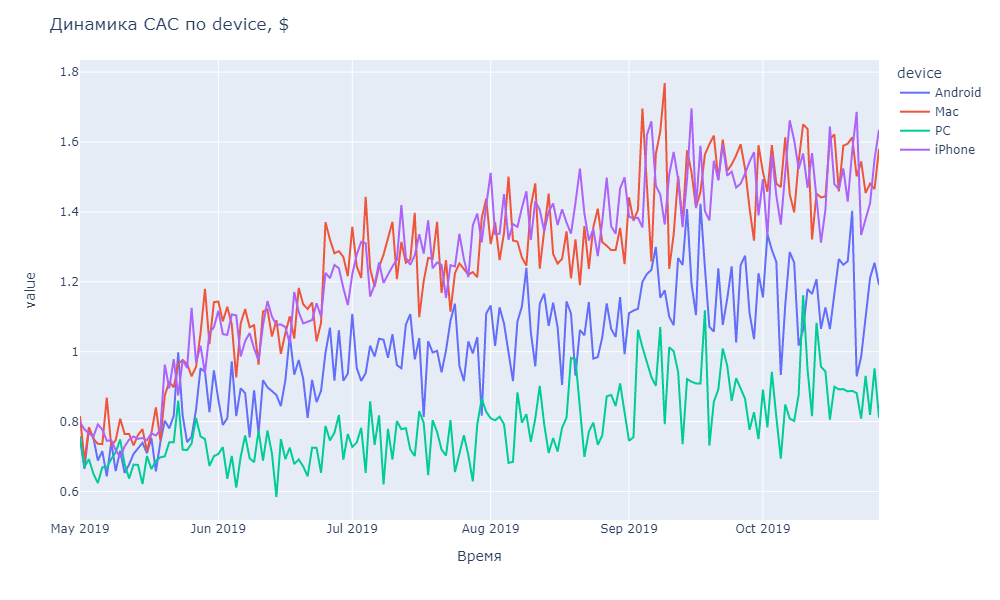

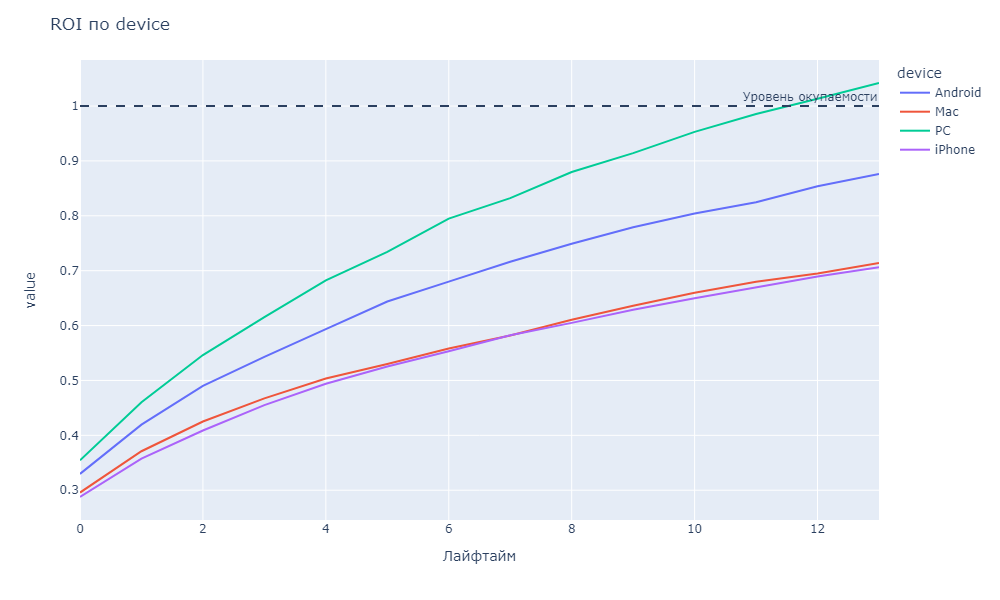

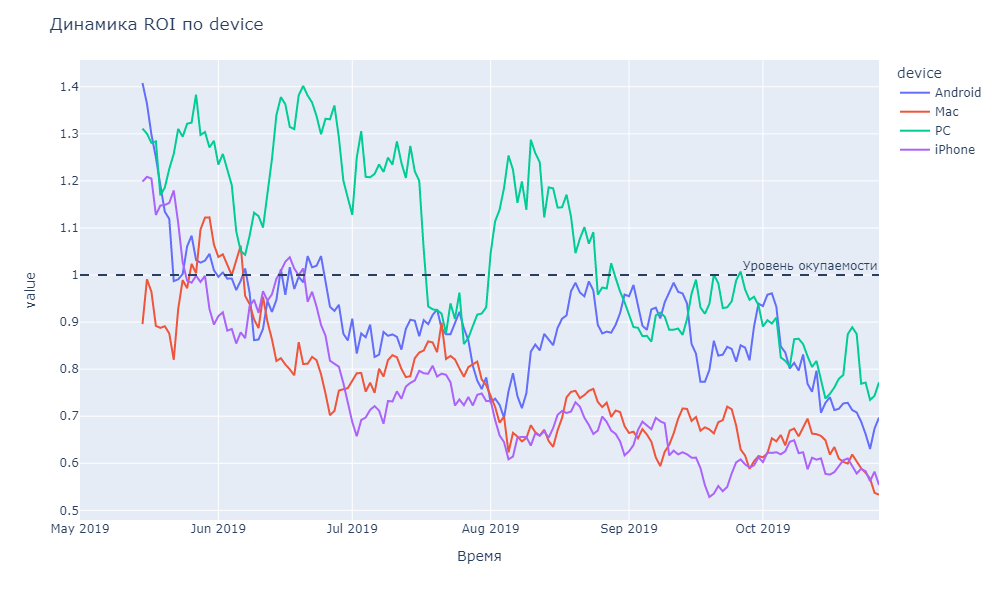

In [25]:
get_plot_ltv_roi (profiles_without_organic, data_orders, '2019.11.01', 14, 15, group = ['device'])

**Вывод:**

LTV пользователей iPhone, Mac и Android распределены примерно одинаково. При этом затраты на привлечение пользователей с iPhone и Mac наиболее высокие.

Показатель CAC для Android и PC стабильно ниже, однако только у пользователей PC на 7-й день привлечения ROI чуть выше 1. Динамика ROI снижается, и на момент анализа ни одна категория пользователей, распределённых по устройствам, не приносит прибыль.

<a id="5.3"></a>
**5.3 Анализ окупаемости рекламы с разбивкой по странам**

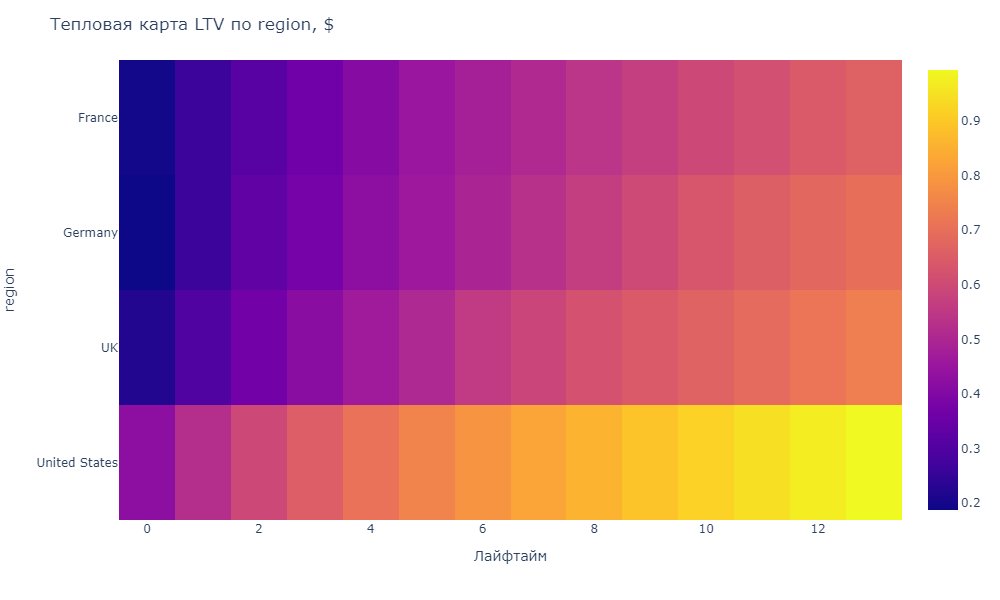

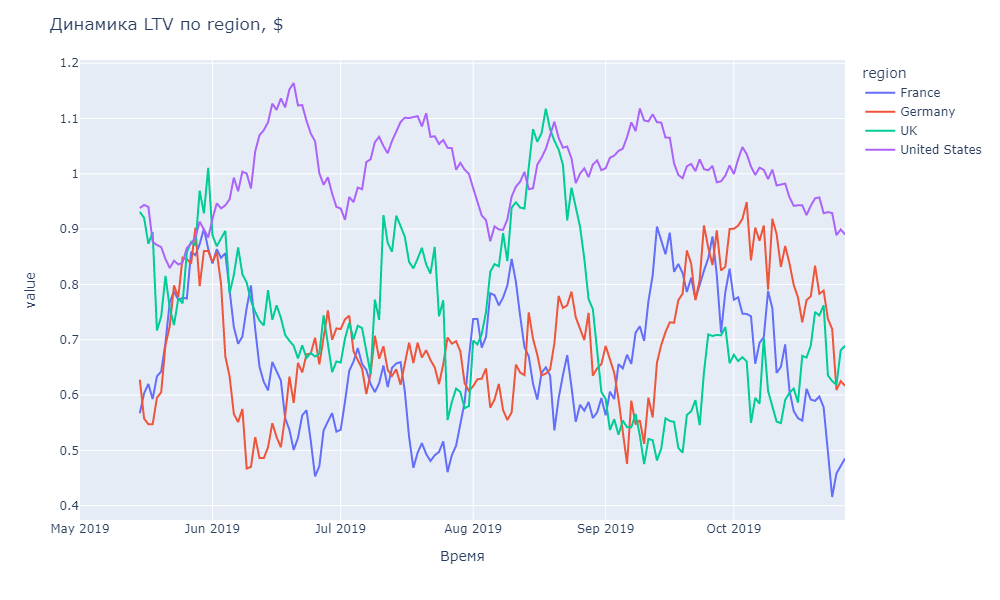

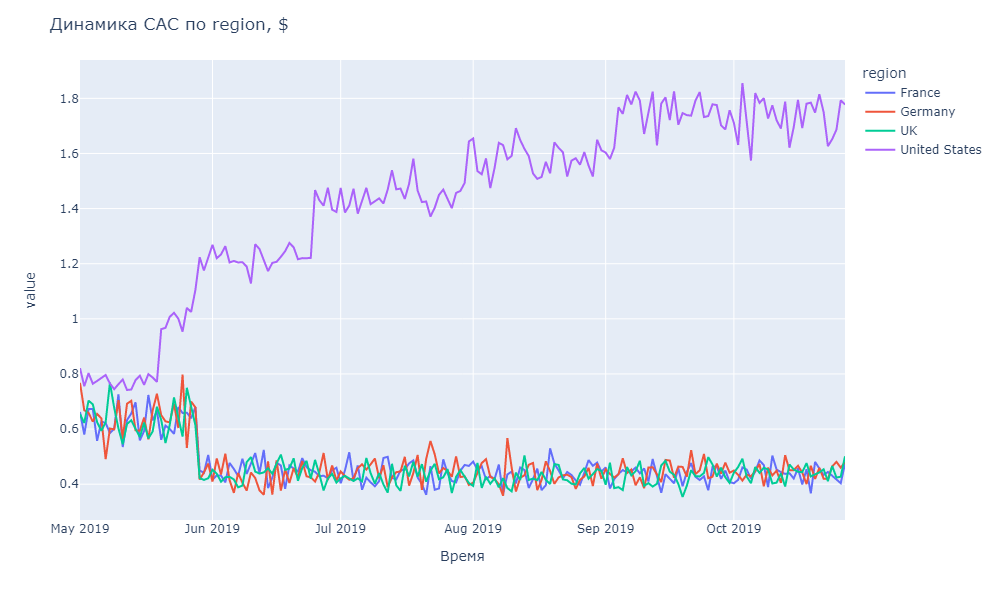

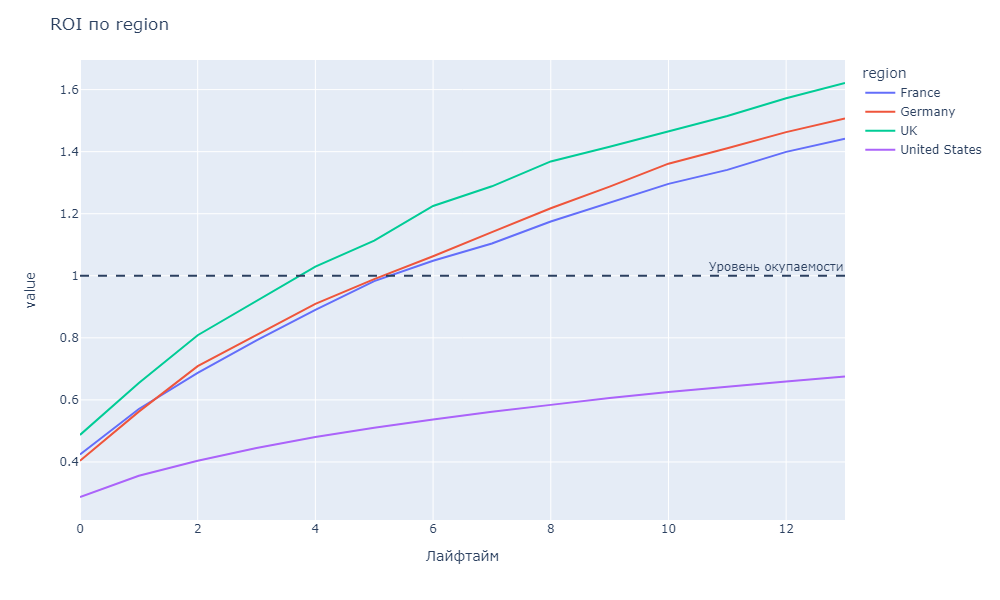

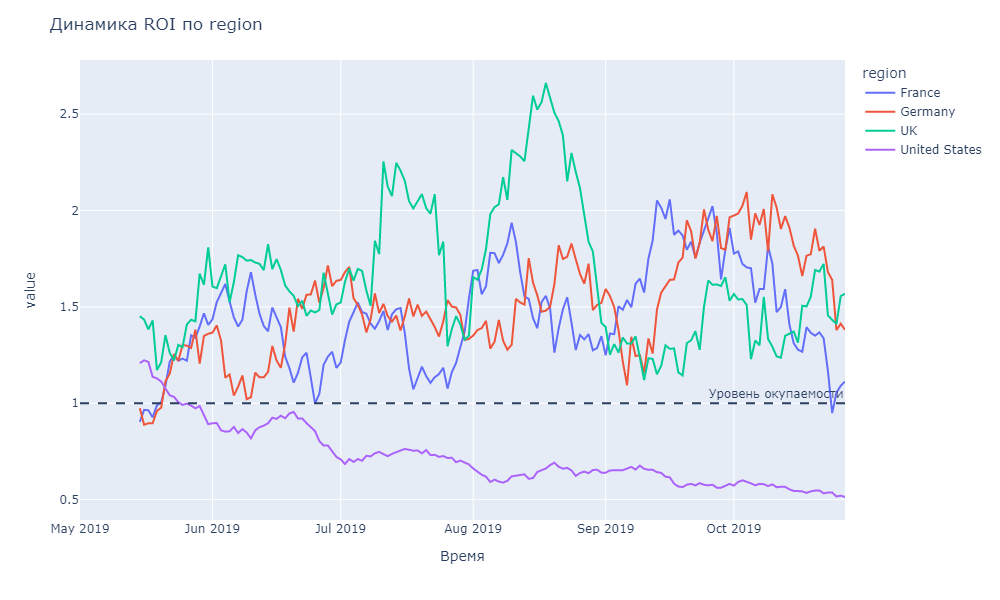

In [26]:
get_plot_ltv_roi (profiles_without_organic, data_orders, '2019.11.01', 14, 15, group = ['region'])

**Вывод:**

США лидирует в распределении LTV, однако динамика LTV одинаково снижается у пользователей во всех регионах. Наименьший LTV у пользователей из Франции.

Динамика затрат на привлечение пользователей стабильна у всех стран, кроме США. На момент анализа стоимость привлечения пользователей в США достигает `1.8$` при среднем показателе `0.45$` для других стран - это колоссальная разница. Вероятно, причина низких показателей проекта кроется именно у пользователей США. Это подтверждается высоким и стабильным ROI у пользователей всех стран, кроме США.

<a id="5.4"></a>
**5.4 Анализ окупаемости рекламы с разбивкой по рекламным каналам**

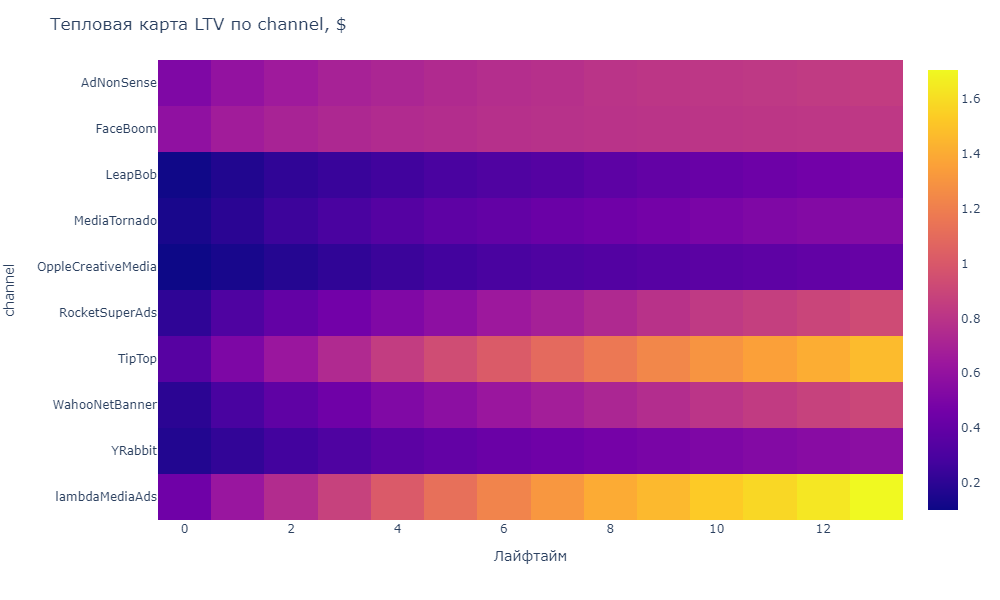

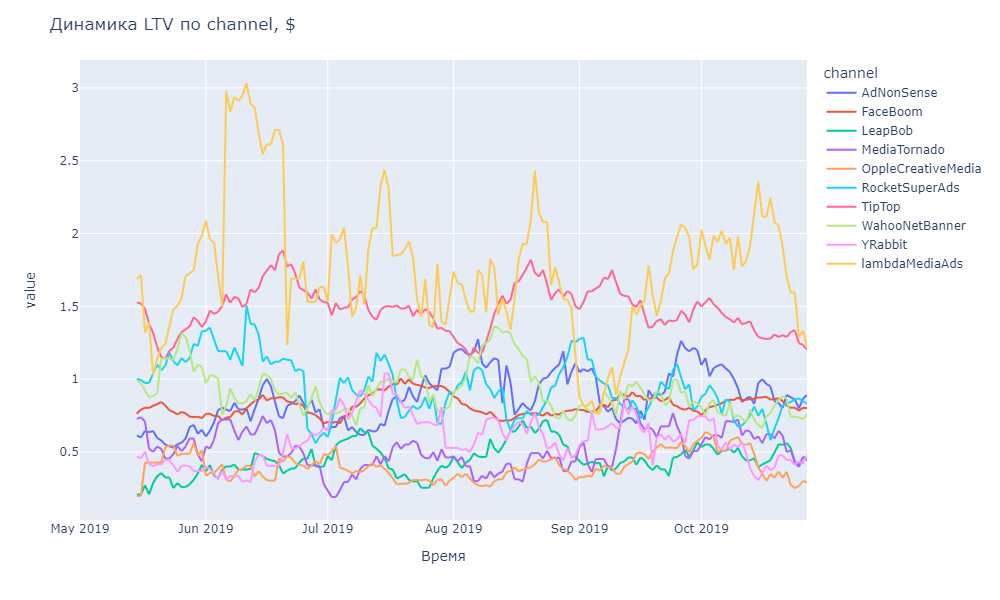

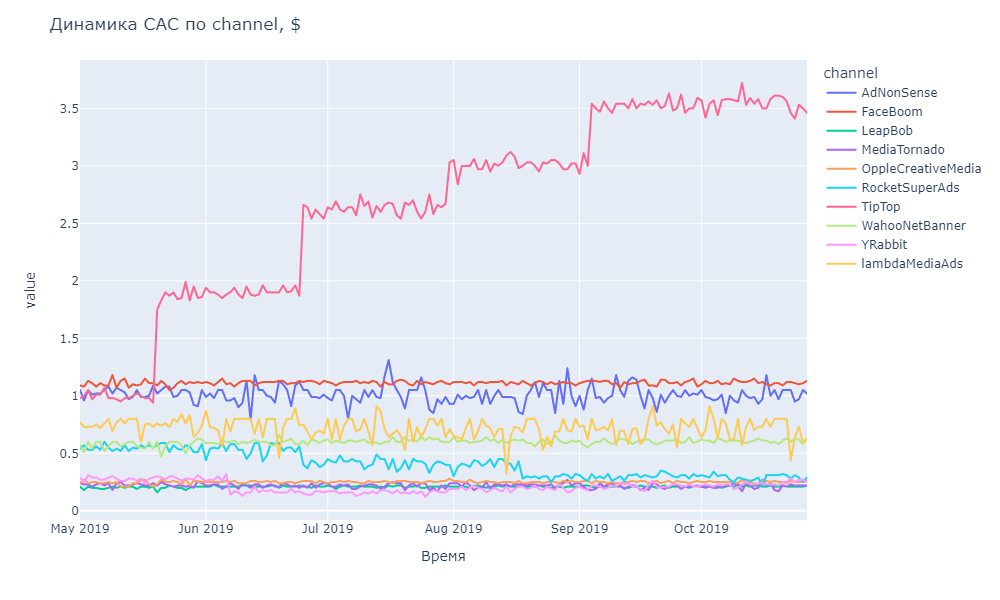

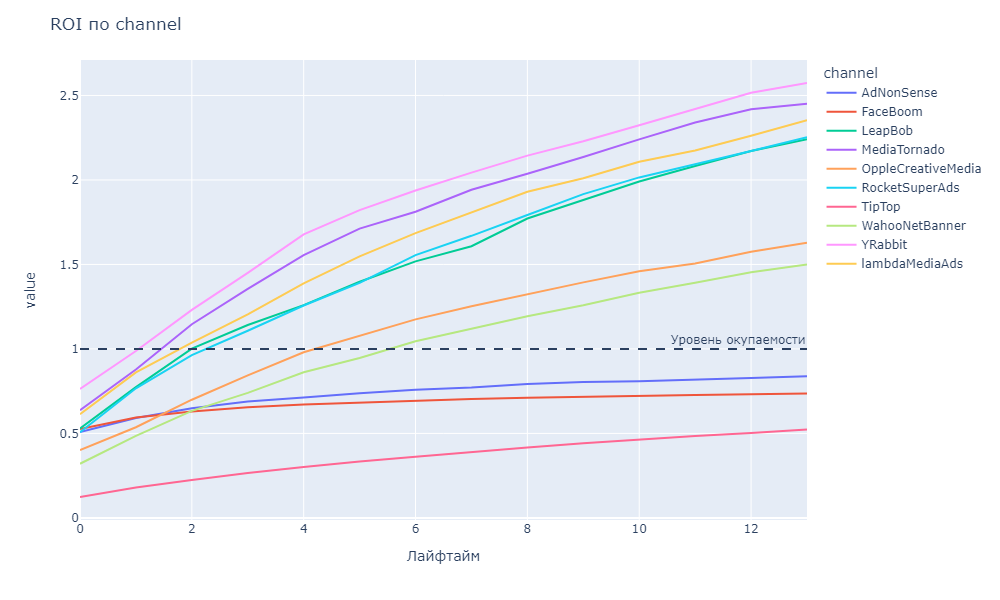

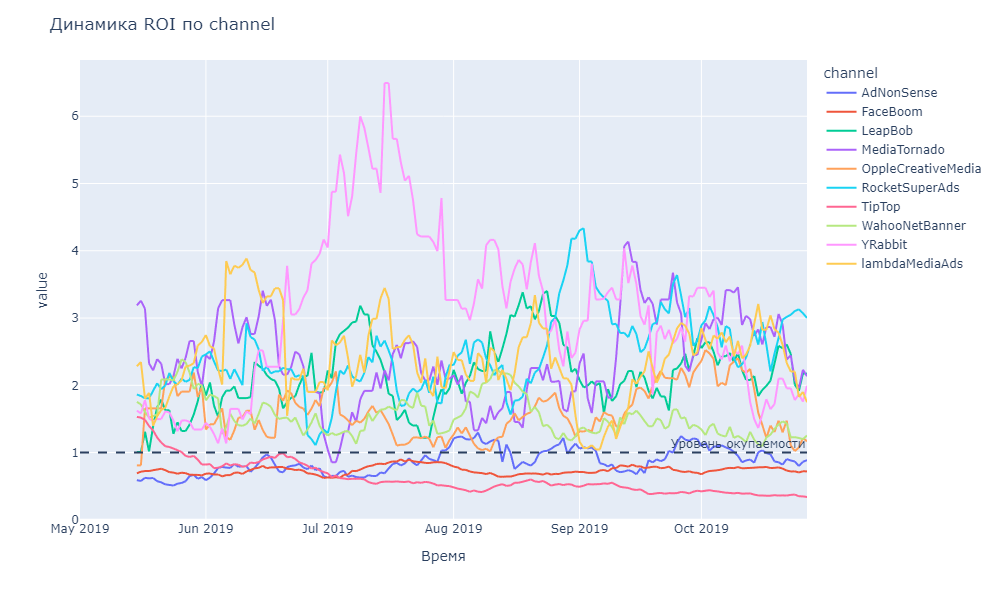

In [27]:
get_plot_ltv_roi (profiles_without_organic, data_orders, '2019.11.01', 14, 15, group = ['channel'])

**Вывод:**

Рекламные каналы `TipTop` и `LambdaMediaAds` имеют самый высокий LTV, однако, динамика LTV у канала `TipTop` регулярно снижается со второй половины августа, в отличие от `LambdaMediaAds`.

Стоимость привлечения одного клиента из канала `TipTop` ежемесячно увеличивалась, в связи с чем `TipTop` - самый дорогой канал привлечения, общие затраты на который превышают 50000$.

ROI также выявил `TipTop` как канал с наихудшей окупаемостью, вместе с `FaceBoom` и `AdNonSence`. Однако, показатель CAC у `TipTop` динамично растёт, в отличие от стабильно высокой цены у `FaceBoom` и `AdNonSence`.

Анализ окупаемости проекта позволил выявить аномально высокую динамику роста у пользователей из США, привлечённых каналом `TipTop` - причину низкой окупаемости проекта следует искать именно в этой категории пользователей.

Наиболее прибыльные каналы привлечения с точки зрения ROI - `YRabbit`, `MediaTornado` и `LambdaMediaAds`.

Стоит также отметить канал `LeapBob` с одним из самых низких показателей CAC и хорошим ROI и канал `RocketSuperAds`, у которого стоимость привлечения постепенно снижается, а по доле платящих пользователей среди всех клиентов данный канал стоит на 5-ом месте, при маленькой доле среди платящих пользователей. Эти два канала имеют перспективы при увеличении рекламного бюджета.

<a id="6"></a>
# 6. Оценка удержания и конверсии
<a id="6.1"></a>

**6.1 Анализ удержания и конверсии по устройствам**

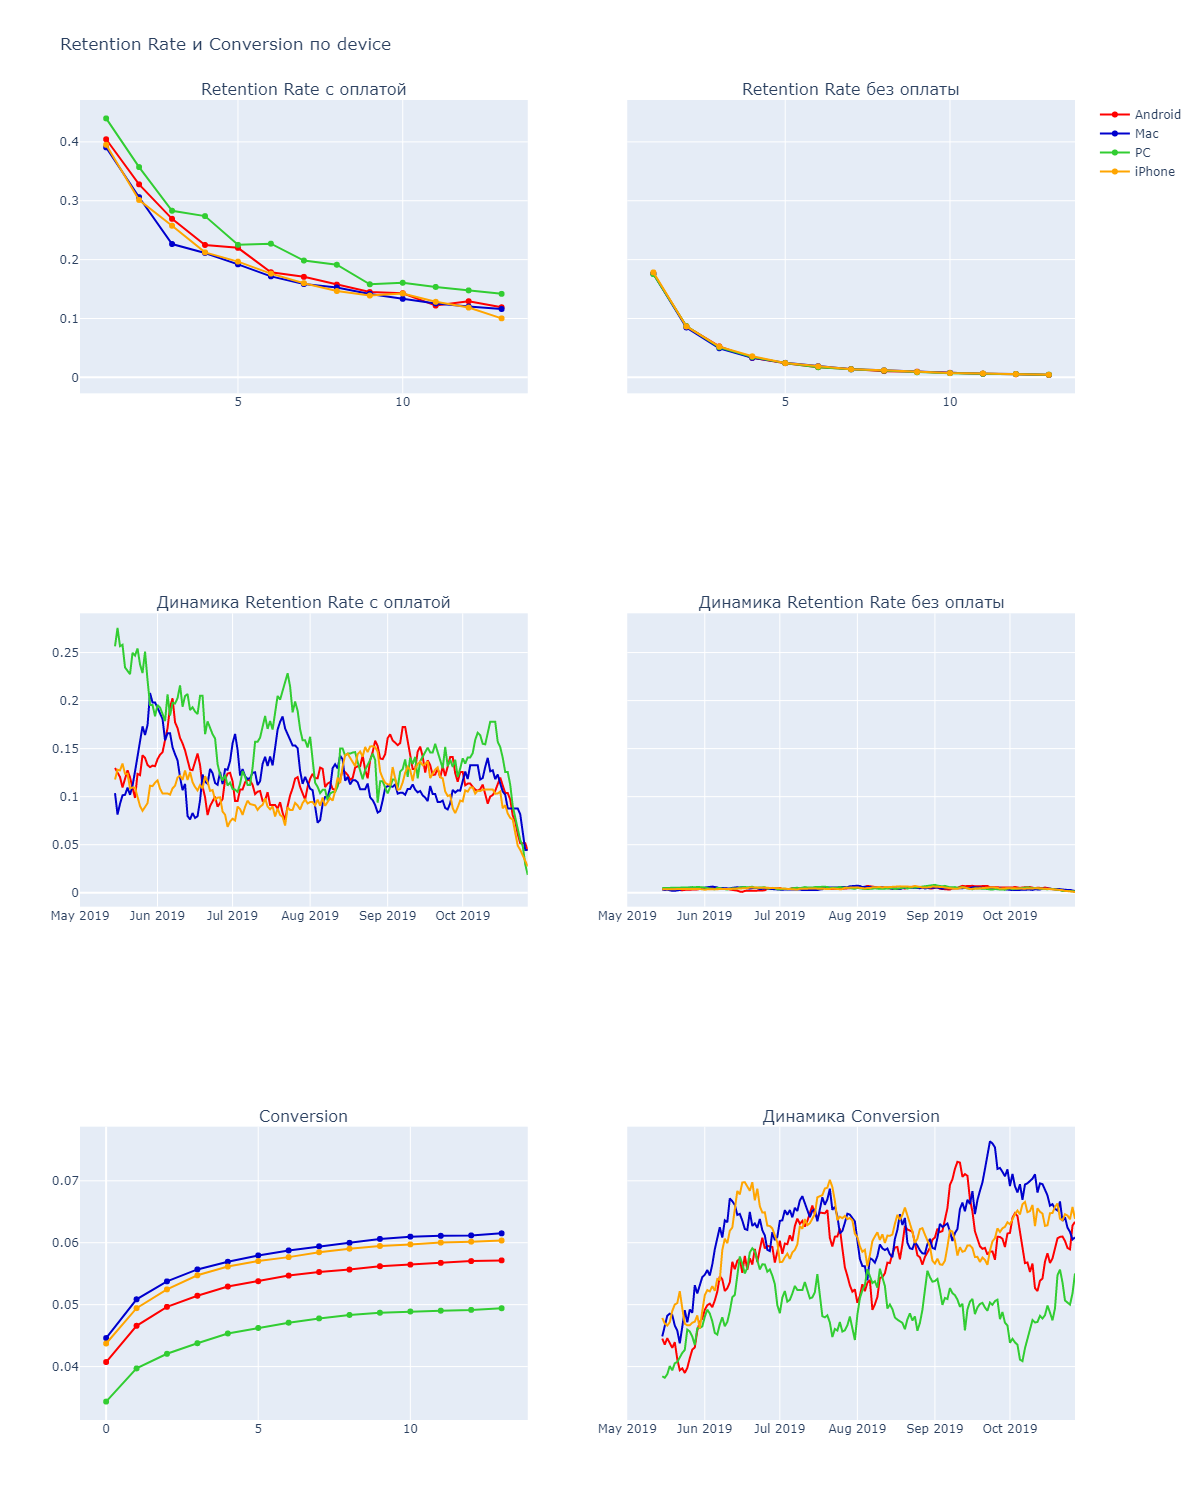

In [28]:
get_plot_retention_convertion (profiles, data_visits, data_orders, '2019.11.01', 14, 15, group = ['device'])

**Вывод:**

Удержание пользователей PC стабильно лучше, чем у остальных пользователей. Удержание пользователей без оплат снижается на одном уровне, при этом удержание платящих клиентов в среднем примерно в два раза выше чем удержание пользователей без оплат.

Динамика удержания резко меняется на протяжение всего временного периода. С июля по август наблюдался резкий взлёт и падение, начиная со второй середины октября динамика сильно ухудшилась по всем пользователям.

Конверсия всех пользователей крайне низкая. Это может говорить о технических проблемах в приложении или настройке рекламных кампаний.

Самая высокая конверсия - у пользователей Mac и IPhone - чуть выше 6%. Динамика конверсии показывает явное расхождение между пользователями Mac и PC: во время роста конверсии пользователей MAC в конце августа, конверсия пользователей PC снижалась, и наоборот, рост конверсии PC в начале октября сопровождался снижением конверсии Mac. Вероятно, это связано с рекламными акциями, проводимыми для пользователей разных когорт в разное время.

<a id="6.2"></a>
**6.2 Анализ удержания и конверсии по странам**

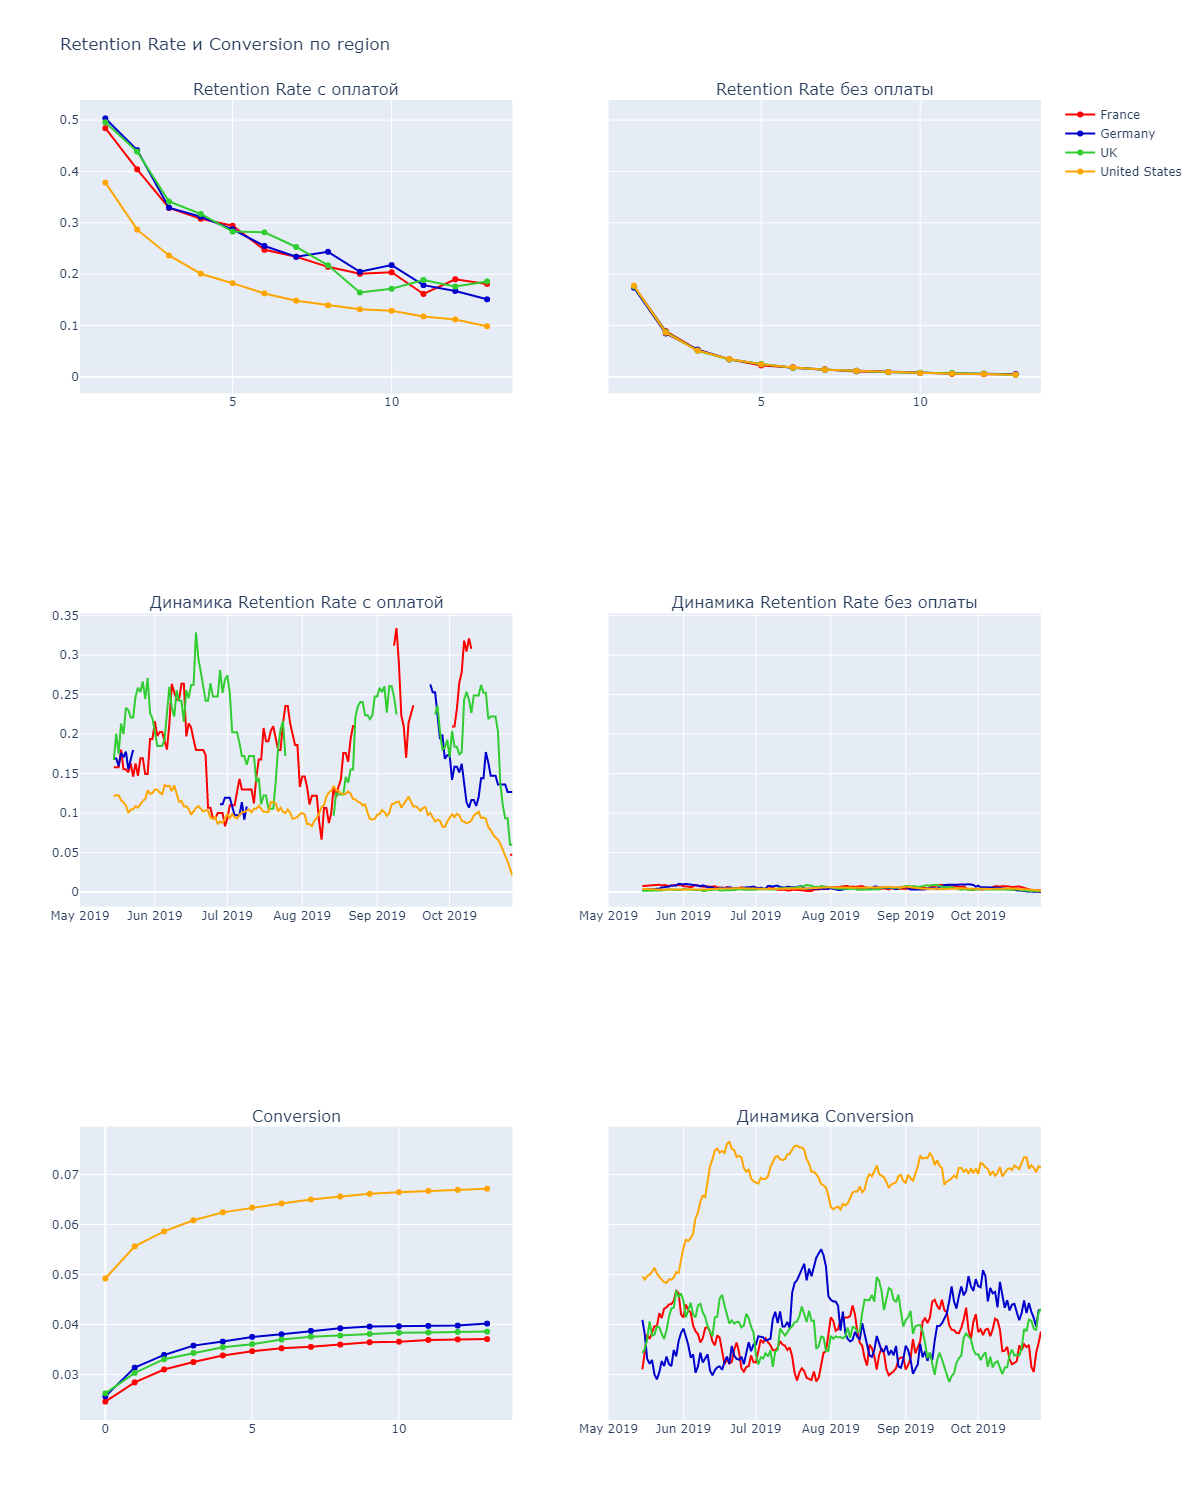

In [29]:
get_plot_retention_convertion (profiles, data_visits, data_orders, '2019.11.01', 14, 15, group = ['region'])

**Вывод:**

Удержание пользователей из США заметно ниже удержания пользователей из остальных стран, это связано с ранее описанными аномалиями в показателях CAC и ROI. При этом пользователи из США имеют самую высокую конверсию, значительно отличающуюся от конверсии остальных стран. В целом конверсия, как и в случае с устройствами, очень низкая у всех пользователей.

<a id="6.3"></a>
**6.3 Анализ удержания и конверсии по рекламным каналам**

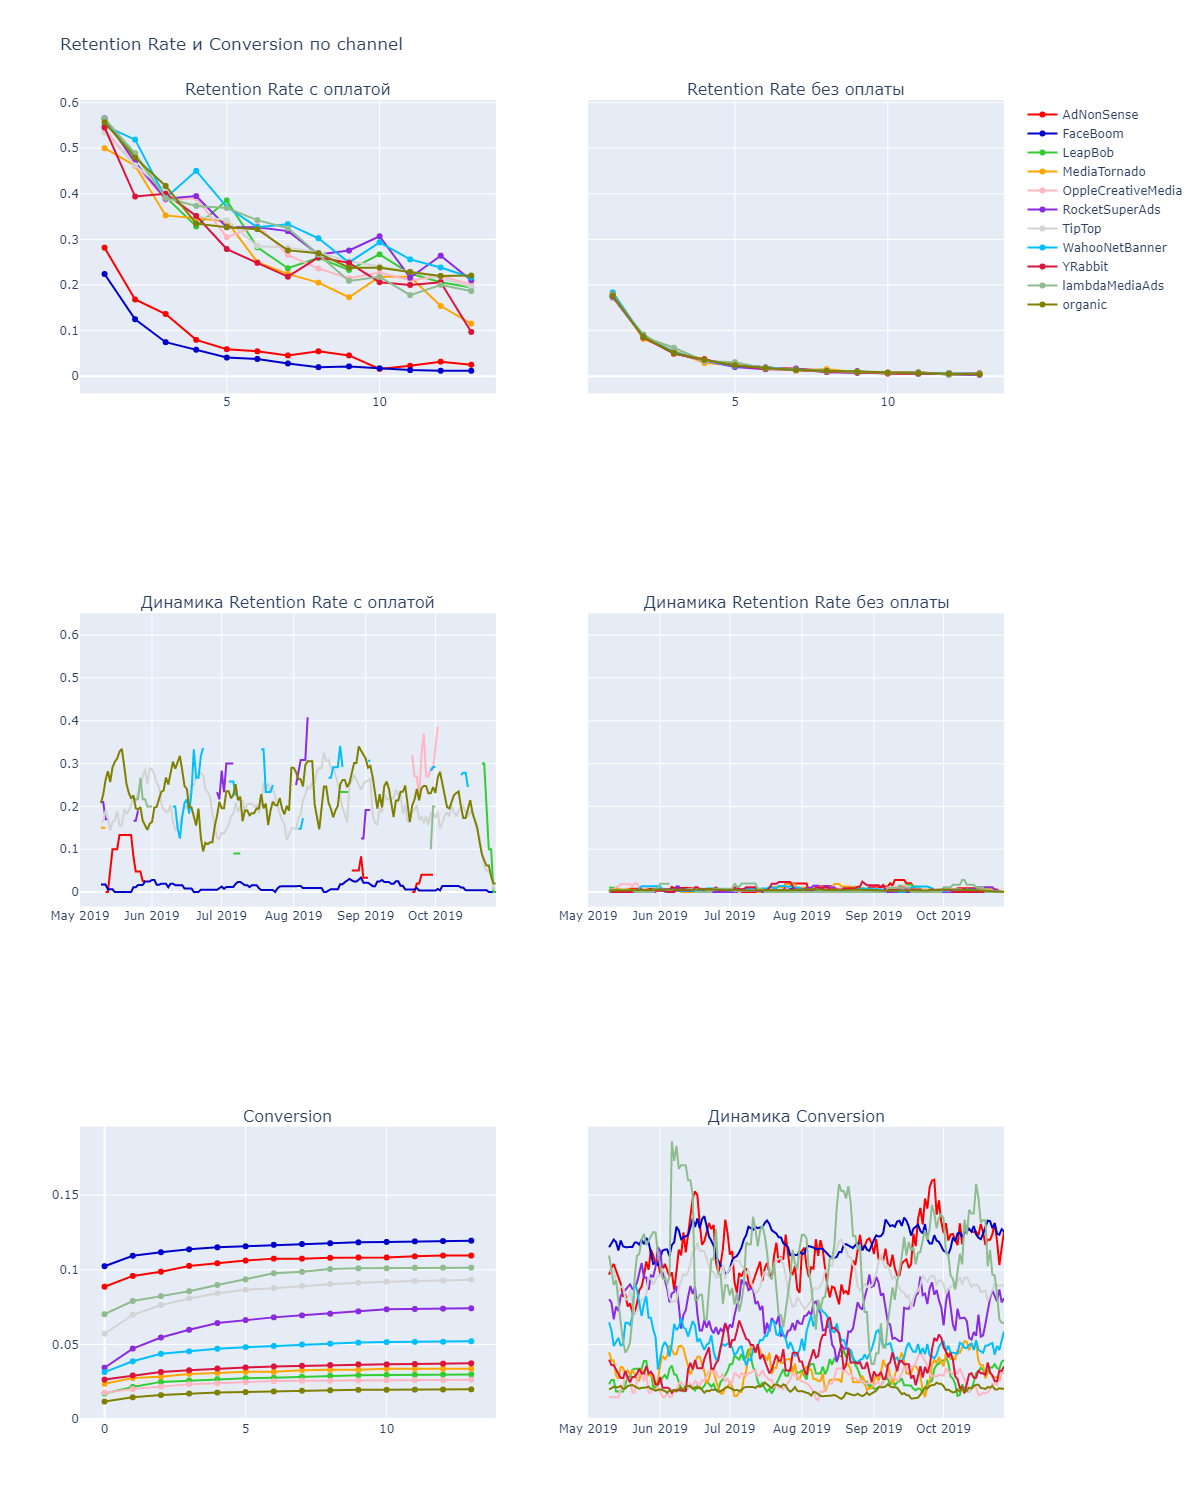

In [30]:
get_plot_retention_convertion (profiles, data_visits, data_orders, '2019.11.01', 14, 10, group = ['channel'])

**Вывод:**

Удержание пользователей с оплатой, привлечённых каналами `AdNonSense` и `FaceBoom` практически на таком же низком уровне как у пользователей без оплаты. Вероятно, низкий показатель удержания у этих двух каналов и является причиной показателей ROI ниже 1, вместе с высокой стоимостью привлечения.

Конверсия у пользователей из всех каналов крайне низкая (< 15%), имеет слабую динамику. Динамика Retention Rate имеет прерывистые и неполные данные. Это может быть связано с отсутствием данных за определённый период или технической ошибкой.

<a id="7"></a>
# 7. Общие выводы и рекомендации

**Основные причины неэфективности:**
* Стремительно увеличивающаяся стоимость привлечения клиентов из США, а также клиентов, привлечённых каналом `TipTop`

* Стабильно высокая стоимость привлечения и очень низкий показатель удержания у каналов `FaceBoom` и `AdNonSense`

* В целом показатели конверсии по всем когортам очень низкие

**Рекомендации для повышения эффективности:**
* Проверить настройки оплаты, перехода на страницу приложения, и взаимодействие с клиентами из США на наличие технических ошибок

* Пересмотреть рекламный бюджет на каналы `FaceBoom` и `AdNonSense`, а также настройки рекламной кампании `TipTop` на наличие технических ошибок при взаимодействии с клиентами

* Обратить внимание на рекламные каналы `YRabbit`, `MediaTornado`, `LambdaMediaAds`, `LeapBob`, `RocketSuperAds` - при текущих значениях CAC данные каналы имеют хорошие перспективы при увеличении рекламного бюджета.